In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
features_data = pd.read_csv('features.csv')
train_data = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')

In [ ]:
df = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

In [ ]:
df.drop(['IsHoliday_y'], axis=1,inplace=True)
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [ ]:
df[df['IsHoliday']==True]['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [ ]:
df['Is_SuperBowl'] = np.where(df['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']),1,0)
df['Is_LaborDay'] = np.where(df['Date'].isin(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']),1,0)
df['Is_Thanksgiving'] = np.where(df['Date'].isin(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']),1,0)
df['Is_Christmas'] = np.where(df['Date'].isin(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']),1,0)

In [ ]:
df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Is_SuperBowl,Is_LaborDay,Is_Thanksgiving,Is_Christmas
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0,0,0,0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,1,0,0,0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,0,0,0,0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,0,0,0,0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,0,0,0,0
5,1,1,2010-03-12,21043.39,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315,0,0,0,0
6,1,1,2010-03-19,22136.64,False,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,A,151315,0,0,0,0
7,1,1,2010-03-26,26229.21,False,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,A,151315,0,0,0,0
8,1,1,2010-04-02,57258.43,False,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,A,151315,0,0,0,0
9,1,1,2010-04-09,42960.91,False,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,A,151315,0,0,0,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df = df.sort_values(by=['Store', 'Dept', 'Date'])

In [ ]:
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64


In [ ]:
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Number of unique weeks:", df['Date'].nunique())
print("Number of unique stores:", df['Store'].nunique())
print("Number of unique departments:", df['Dept'].nunique())

Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Number of unique weeks: 143
Number of unique stores: 45
Number of unique departments: 81


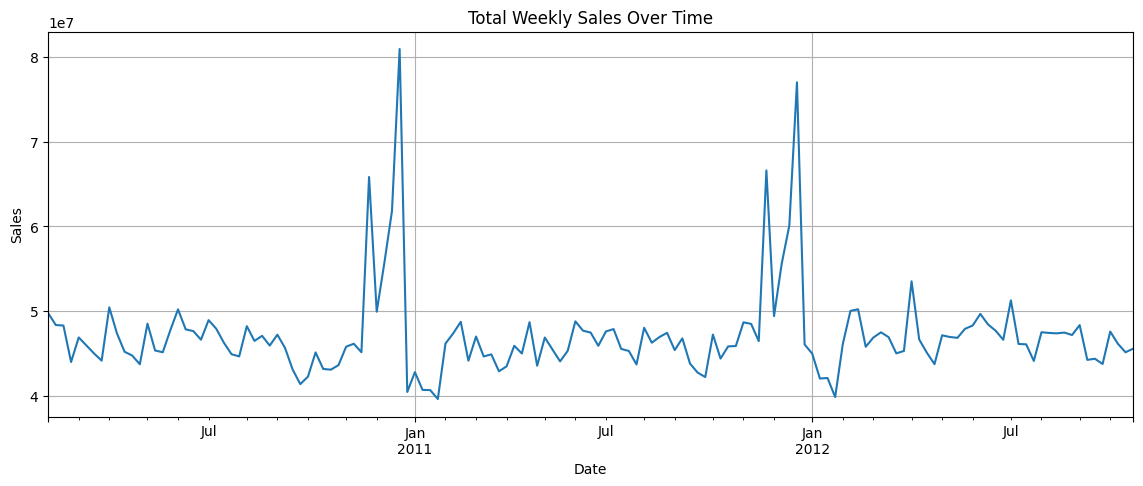

In [ ]:
plt.figure(figsize=(14, 5))
df.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [ ]:
sample = df[(df['Store'] == 1) & (df['Dept'] == 1)].set_index('Date')
sample = sample.resample('W').sum()

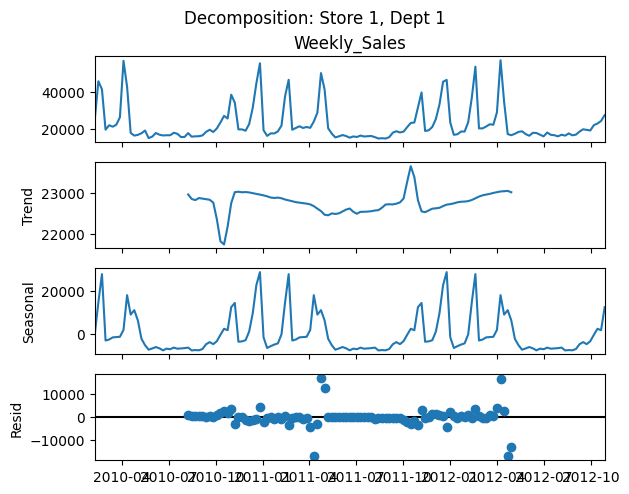

In [ ]:
result = seasonal_decompose(sample['Weekly_Sales'], model='additive', period=52)
result.plot()
plt.suptitle("Decomposition: Store 1, Dept 1", y=1.02)
plt.show()

In [ ]:
# 1. Observed (Top Panel)
# This is the original sales time series.

# You can see strong recurring peaks, likely aligning with holidays or seasonal shopping periods (e.g., Thanksgiving, Christmas).

# Sharp fluctuations indicate high seasonality.

# 2. Trend (Second Panel)
# The trend was stable early on, then dipped slightly around late 2010 to mid-2011, and rose again.

# This suggests some long-term changes in sales behavior, possibly due to promotions, competition, or economic factors.

# 3. Seasonal (Third Panel)
# Very clear and strong weekly/annual seasonality.

# The regular spikes align with a 52-week seasonality assumption—exactly what you want to model in ARIMA, TFT, or XGBoost with time features.

# This means you must include seasonal indicators (e.g. week of year, month, is_holiday) in your modeling.

# 4. Residual (Bottom Panel)
# The residuals are scattered with some large outliers.

# However, there's no strong autocorrelation or obvious pattern left, which suggests that most systematic patterns (trend + seasonality) are captured.

# Large outliers may correspond to promotions, markdown events, or unmarked holidays.

In [ ]:
# Your series is not stationary (due to trend and seasonality), so you will need differencing or seasonal differencing for ARIMA models.

# The seasonality is strong and consistent, so using Fourier terms, lag features, or one-hot encoded holidays will help tree-based models and TFT.

# The decomposition confirms that store and department-level modeling is valid since different depts may have distinct seasonal patterns.

In [ ]:
# Example: create lag features for Weekly_Sales
# You should do this per (Store, Dept) group

lags = [1, 2, 3, 4, 52]  # Common lags: 1–4 weeks and 1 year (52 weeks)

for lag in lags:
    df[f'Weekly_Sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

Top 10 Stores by Sales:
 Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
Name: Weekly_Sales, dtype: float64
Top 10 Departments by Sales:
 Dept
92    4.839433e+08
95    4.493202e+08
38    3.931181e+08
72    3.057252e+08
90    2.910685e+08
40    2.889360e+08
2     2.806112e+08
91    2.167817e+08
13    1.973216e+08
8     1.942808e+08
Name: Weekly_Sales, dtype: float64


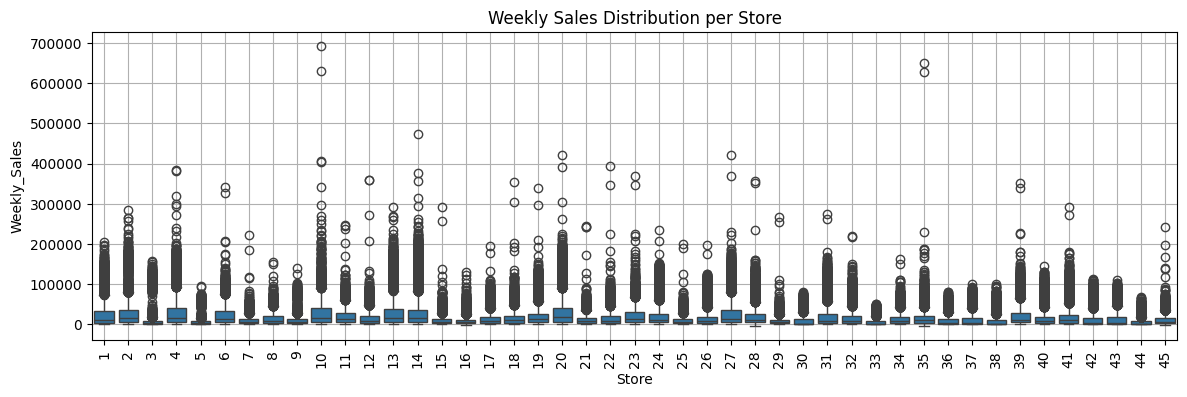

In [ ]:
# Top 10 stores by total sales
top_stores = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
print("Top 10 Stores by Sales:\n", top_stores)

# Top 10 departments by total sales
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
print("Top 10 Departments by Sales:\n", top_depts)

# Plot sales distribution by store
plt.figure(figsize=(14, 4))
sns.boxplot(data=df, x='Store', y='Weekly_Sales')
plt.title("Weekly Sales Distribution per Store")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF test on one sample series: Store 1, Dept 1
sample = df[(df['Store'] == 1) & (df['Dept'] == 1)].sort_values('Date')
sales_series = sample['Weekly_Sales'].dropna()

adf_result = adfuller(sales_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("✅ Series is likely stationary")
else:
    print("❌ Series is likely non-stationary")

ADF Statistic: -2.5221638686500367
p-value: 0.11017432282586997
❌ Series is likely non-stationary


In [ ]:
sample['Weekly_Sales_diff1'] = sample['Weekly_Sales'].diff()

# Re-run ADF test
result = adfuller(sample['Weekly_Sales_diff1'].dropna())
print("ADF after differencing:", result[0])
print("p-value:", result[1])

##Series are now stationary


ADF after differencing: -11.044311466768818
p-value: 5.269934445888141e-20


In [ ]:
df['Sales_diff1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].diff()   ###  ამ ცვლადს არ ვიყენებთ ARIMA მოდელებში!!!

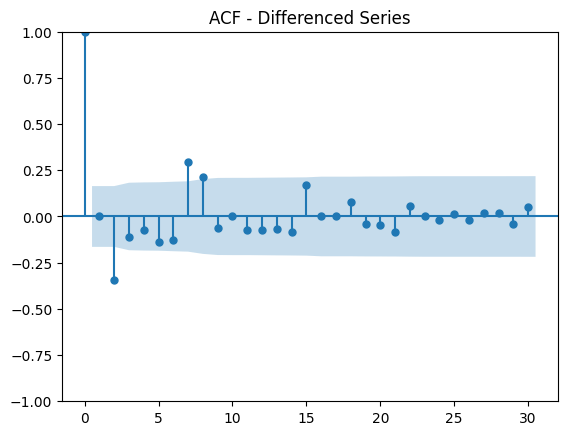

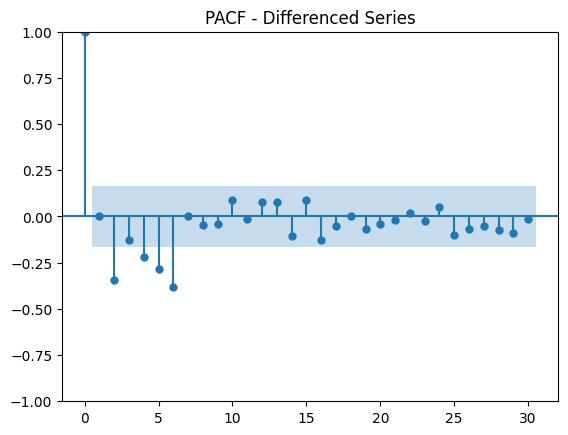

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for differenced series
plot_acf(sample['Weekly_Sales_diff1'].dropna(), lags=30)
plt.title('ACF - Differenced Series')
plt.show()

plot_pacf(sample['Weekly_Sales_diff1'].dropna(), lags=30)
plt.title('PACF - Differenced Series')
plt.show()

In [ ]:

# A significant positive spike at lag 7, suggesting weekly seasonality
# Most other lags fall within the confidence bands (blue shaded area)
# The pattern suggests the series may still have some seasonal correlation after differencing

# PACF Plot (bottom):
# Several significant spikes in the early lags (1-6), with some negative values
# A notable spike around lag 7, reinforcing the weekly seasonal pattern
# Most lags beyond 7 fall within the confidence bounds

# The differenced series appears to be mostly stationary, but the significant spike at lag 7 in both plots strongly suggests a weekly seasonal pattern that may need additional treatment.
# If we use SARIMA, we can try d=1 and D=1

In [ ]:
# 1. MISSING VALUES AND DATA QUALITY ANALYSIS
print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
# Check missing values pattern
missing_summary = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing_summary, 'Missing_Percentage': missing_pct})
print(missing_df[missing_df['Missing_Count'] > 0])


MISSING VALUES ANALYSIS
                     Missing_Count  Missing_Percentage
MarkDown1                   270889           64.257181
MarkDown2                   310322           73.611025
MarkDown3                   284479           67.480845
MarkDown4                   286603           67.984676
MarkDown5                   270138           64.079038
Weekly_Sales_lag_1            3331            0.790142
Weekly_Sales_lag_2            6625            1.571507
Weekly_Sales_lag_3            9889            2.345755
Weekly_Sales_lag_4           13134            3.115497
Weekly_Sales_lag_52         160487           38.068885
Sales_diff1                   3331            0.790142


In [ ]:
# Check for zero sales (could indicate closed stores/departments)
zero_sales = (df['Weekly_Sales'] == 0).sum()
print(f"\nZero sales records: {zero_sales} ({zero_sales/len(df)*100:.2f}%)")

# Check negative sales
negative_sales = (df['Weekly_Sales'] < 0).sum()
print(f"Negative sales records: {negative_sales} ({negative_sales/len(df)*100:.2f}%)")



Zero sales records: 73 (0.02%)
Negative sales records: 1285 (0.30%)


In [ ]:
df = df[df['Weekly_Sales']>=0]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter


TEMPORAL PATTERNS ANALYSIS
Sales by Year:
               sum          mean           std
Year                                          
2010  2.288919e+09  16315.740243  23079.103142
2011  2.448233e+09  16004.658586  22884.806678
2012  2.000156e+09  15746.033424  22138.162734


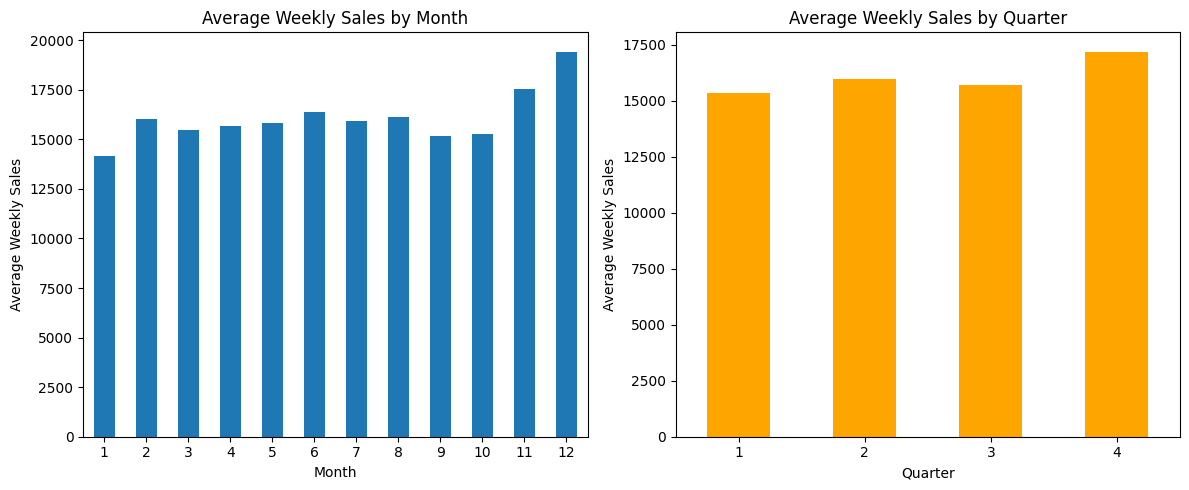

In [ ]:

# 2. TEMPORAL PATTERNS ANALYSIS
print("\n" + "="*50)
print("TEMPORAL PATTERNS ANALYSIS")
print("="*50)
# Sales by year
yearly_sales = df.groupby('Year')['Weekly_Sales'].agg(['sum', 'mean', 'std'])
print("Sales by Year:")
print(yearly_sales)

# Monthly seasonality
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean().sort_index()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
monthly_sales.plot(kind='bar')
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

# Quarterly patterns
quarterly_sales = df.groupby('Quarter')['Weekly_Sales'].mean()
plt.subplot(1, 2, 2)
quarterly_sales.plot(kind='bar', color='orange')
plt.title('Average Weekly Sales by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Better approach for holiday hypothesis testing
print("\n" + "="*50)
print("IMPROVED HOLIDAY IMPACT ANALYSIS")
print("="*50)

# Method 1: Sample a subset of store-department combinations
np.random.seed(42)
unique_combinations = df[['Store', 'Dept']].drop_duplicates()
sample_combinations = unique_combinations.sample(n=min(50, len(unique_combinations)))

sampled_data = df.merge(sample_combinations, on=['Store', 'Dept'])
holiday_sales_sample = sampled_data[sampled_data['IsHoliday'] == True]['Weekly_Sales']
non_holiday_sales_sample = sampled_data[sampled_data['IsHoliday'] == False]['Weekly_Sales']

t_stat_sample, p_value_sample = stats.ttest_ind(holiday_sales_sample, non_holiday_sales_sample)
print(f"Sampled T-test: t-statistic = {t_stat_sample:.4f}, p-value = {p_value_sample:.4f}")

# Method 2: Aggregate at store-department level first (better approach)
store_dept_holiday_effect = []
for (store, dept), group in df.groupby(['Store', 'Dept']):
    if len(group[group['IsHoliday'] == True]) > 0 and len(group[group['IsHoliday'] == False]) > 0:
        holiday_mean = group[group['IsHoliday'] == True]['Weekly_Sales'].mean()
        non_holiday_mean = group[group['IsHoliday'] == False]['Weekly_Sales'].mean()
        holiday_lift = (holiday_mean - non_holiday_mean) / non_holiday_mean * 100
        store_dept_holiday_effect.append({
            'Store': store,
            'Dept': dept,
            'Holiday_Mean': holiday_mean,
            'NonHoliday_Mean': non_holiday_mean,
            'Holiday_Lift_Pct': holiday_lift
        })

holiday_effect_df = pd.DataFrame(store_dept_holiday_effect)

holiday_lifts = holiday_effect_df['Holiday_Lift_Pct'].dropna()
t_stat_lift, p_value_lift = stats.ttest_1samp(holiday_lifts, 0)
print(f"\nOne-sample t-test (Holiday lift vs 0%): t-statistic = {t_stat_lift:.4f}, p-value = {p_value_lift:.4f}")
print(f"Mean holiday lift across store-dept combinations: {holiday_lifts.mean():.2f}%")
print(f"Standard deviation of holiday lift: {holiday_lifts.std():.2f}%")


IMPROVED HOLIDAY IMPACT ANALYSIS
Sampled T-test: t-statistic = 0.3889, p-value = 0.6974

One-sample t-test (Holiday lift vs 0%): t-statistic = 4.1708, p-value = 0.0000
Mean holiday lift across store-dept combinations: 17.49%
Standard deviation of holiday lift: 237.00%


In [ ]:
# The high standard deviation (237%) is the key insight here. It tells us:

# Some store-department combinations see massive holiday boosts
# Others might actually see decreases during holidays
# The holiday effect is highly heterogeneous across business units


EXTERNAL FACTORS CORRELATION
Correlation with Weekly Sales:
Fuel_Price      0.000092
Temperature    -0.002333
CPI            -0.021153
Unemployment   -0.025831
Name: Weekly_Sales, dtype: float64


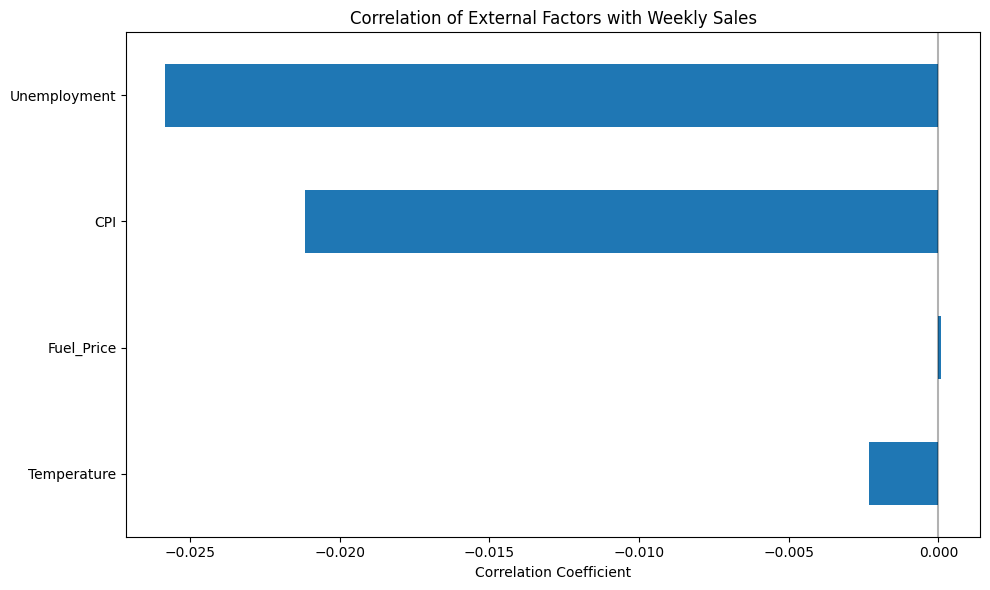

In [ ]:
# 4. EXTERNAL FACTORS CORRELATION ANALYSIS
print("\n" + "="*50)
print("EXTERNAL FACTORS CORRELATION")
print("="*50)

# Correlation with external factors
external_factors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
available_factors = [col for col in external_factors if col in df.columns and df[col].notna().sum() > 0]

if available_factors:
    correlation_matrix = df[['Weekly_Sales'] + available_factors].corr()['Weekly_Sales'].drop('Weekly_Sales')
    print("Correlation with Weekly Sales:")
    print(correlation_matrix.sort_values(ascending=False))

    # Visualize correlations
    plt.figure(figsize=(10, 6))
    correlation_matrix.plot(kind='barh')
    plt.title('Correlation of External Factors with Weekly Sales')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# These weak correlations indicate they won't be predictive in their current form

In [ ]:
for col in ['Fuel_Price', 'CPI', 'Unemployment']:
    if col in df.columns:
        df[f'{col}_change'] = df.groupby(['Store', 'Dept'])[col].diff()
        df[f'{col}_pct_change'] = df.groupby(['Store', 'Dept'])[col].pct_change()


for lag in [1, 2, 4, 8, 12]:
    for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
        if col in df.columns:
            df[f'{col}_lag_{lag}'] = df.groupby(['Store', 'Dept'])[col].shift(lag)


OUTLIER ANALYSIS
Outliers detected: 35381 (8.42%)
Lower bound: $-25,108.67
Upper bound: $47,494.61


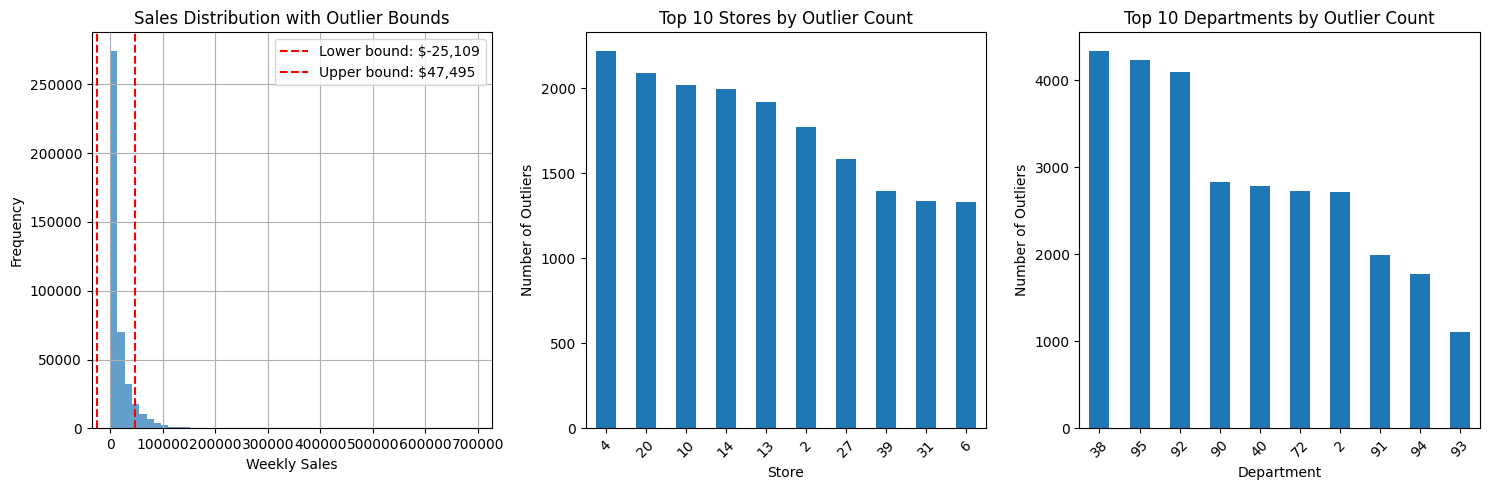

In [ ]:
# OUTLIER DETECTION


print("\n" + "="*50)
print("OUTLIER ANALYSIS")
print("="*50)

Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]
print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")

outlier_by_store = outliers.groupby('Store').size().sort_values(ascending=False).head(10)
outlier_by_dept = outliers.groupby('Dept').size().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df['Weekly_Sales'].hist(bins=50, alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound: ${lower_bound:,.0f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound: ${upper_bound:,.0f}')
plt.title('Sales Distribution with Outlier Bounds')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 2)
outlier_by_store.plot(kind='bar')
plt.title('Top 10 Stores by Outlier Count')
plt.xlabel('Store')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
outlier_by_dept.plot(kind='bar')
plt.title('Top 10 Departments by Outlier Count')
plt.xlabel('Department')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Outlier handling

In [ ]:
df['is_outlier'] = ((df['Weekly_Sales'] < -25108.67) | (df['Weekly_Sales'] > 847494.61)).astype(int)
outlier_propensity_store = df.groupby('Store')['is_outlier'].mean()
outlier_propensity_dept = df.groupby('Dept')['is_outlier'].mean()
df['store_outlier_propensity'] = df['Store'].map(outlier_propensity_store)
df['dept_outlier_propensity'] = df['Dept'].map(outlier_propensity_dept)
df['is_outlier_lag1'] = df.groupby(['Store', 'Dept'])['is_outlier'].shift(1)
df['outlier_count_last_4weeks'] = df.groupby(['Store', 'Dept'])['is_outlier'].rolling(4).sum().shift(1).reset_index(level=[0,1], drop=True)
df.drop('is_outlier', axis=1, inplace=True)


CROSS-SECTIONAL HETEROGENEITY
Sales Volatility Analysis:
Average CV across stores: 1.326
CV standard deviation: 0.221


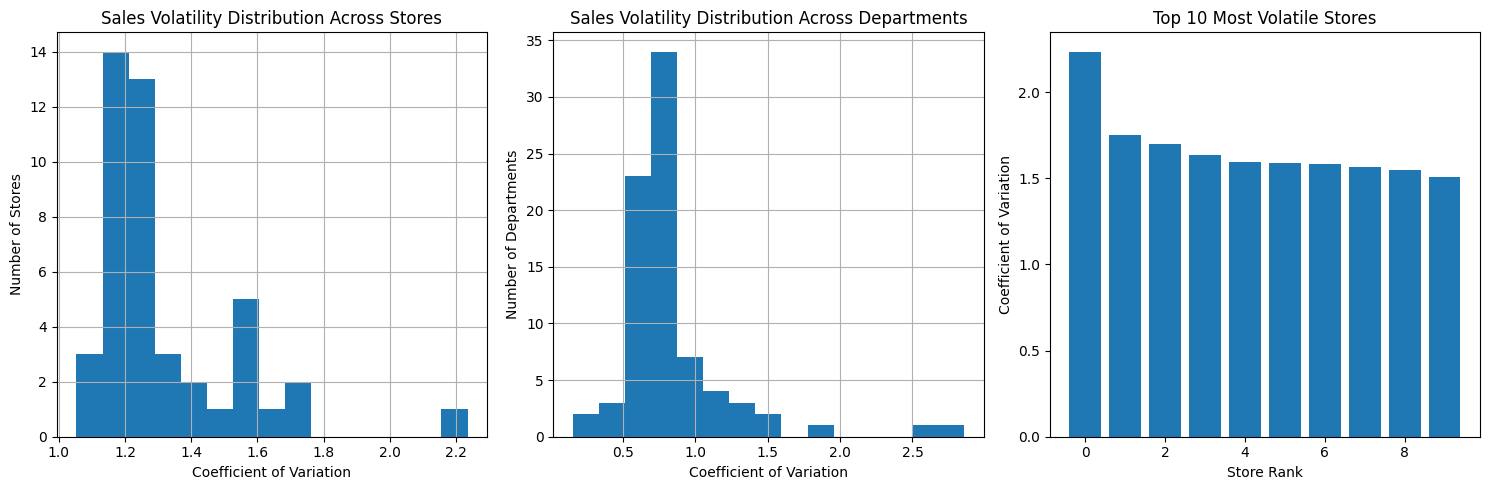

In [ ]:
# 6. CROSS-SECTIONAL ANALYSIS
print("\n" + "="*50)
print("CROSS-SECTIONAL HETEROGENEITY")
print("="*50)

# Coefficient of variation by store (sales volatility)
store_cv = df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std']).reset_index()
store_cv['CV'] = store_cv['std'] / store_cv['mean']
print("Sales Volatility Analysis:")
print(f"Average CV across stores: {store_cv['CV'].mean():.3f}")
print(f"CV standard deviation: {store_cv['CV'].std():.3f}")

# Department volatility
dept_cv = df.groupby('Dept')['Weekly_Sales'].agg(['mean', 'std']).reset_index()
dept_cv['CV'] = dept_cv['std'] / dept_cv['mean']

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
store_cv['CV'].hist(bins=15)
plt.title('Sales Volatility Distribution Across Stores')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Number of Stores')

plt.subplot(1, 3, 2)
dept_cv['CV'].hist(bins=15)
plt.title('Sales Volatility Distribution Across Departments')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Number of Departments')

plt.subplot(1, 3, 3)
top_volatile_stores = store_cv.nlargest(10, 'CV')
plt.bar(range(len(top_volatile_stores)), top_volatile_stores['CV'])
plt.title('Top 10 Most Volatile Stores')
plt.xlabel('Store Rank')
plt.ylabel('Coefficient of Variation')
plt.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270085
MarkDown2,309367
MarkDown3,283618


In [ ]:
# 1. DROP MARKDOWN COLUMNS (they're mostly empty)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
print("Dropping markdown columns with >90% missing values:")
for col in markdown_cols:
    if col in df.columns:
        missing_pct = df[col].isnull().sum() / len(df) * 100
        print(f"{col}: {missing_pct:.1f}% missing")
        df = df.drop(columns=[col])

print("✅ Markdown columns dropped")

# 2. HANDLE LAG FEATURES PROPERLY
print("\n2. Fixing lag feature missingness:")

# Lag features should have missing values at the beginning of each series
lag_cols = [col for col in df.columns if 'lag' in col.lower()]
for col in lag_cols:
    if col in df.columns:
        # Check if missing values are at series starts (expected) or random (problematic)
        df_sorted = df.sort_values(['Store', 'Dept', 'Date'])
        missing_pattern = df_sorted.groupby(['Store', 'Dept'])[col].apply(
            lambda x: x.isnull().sum()
        )

        expected_missing = int(col.split('_')[-1]) if col.split('_')[-1].isdigit() else 1
        problematic_series = (missing_pattern > expected_missing * 2).sum()

        if problematic_series > 0:
            print(f"⚠️  {col}: {problematic_series} series with unexpected missing pattern")
        else:
            print(f"✅ {col}: Missing pattern looks normal")

# 3. HANDLE EXTERNAL FACTOR DERIVED FEATURES
print("\n3. Handling external factor derived features:")

external_derived_cols = [col for col in df.columns if any(x in col for x in ['change', 'pct_change'])
                        and any(y in col for y in ['Fuel_Price', 'CPI', 'Unemployment', 'Temperature'])]

for col in external_derived_cols:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"{col}: {missing_count} missing values")

            # For change features, first value in each series should be NaN (expected)
            # Fill remaining with 0 (no change) or forward fill
            if 'change' in col:
                df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')
                df[col] = df[col].fillna(0)  # Fill any remaining with 0
                print(f"✅ Fixed {col}")

# 4. VERIFY OUTLIER FEATURES
print("\n4. Checking outlier features:")
outlier_cols = [col for col in df.columns if 'outlier' in col.lower()]
for col in outlier_cols:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"⚠️  {col}: {missing_count} missing - needs attention")
            # Fill outlier flags with 0 (not an outlier)
            df[col] = df[col].fillna(0)
        else:
            print(f"✅ {col}: No missing values")

# 5. FINAL CLEANUP
print("\n5. Final missing value cleanup:")

# Drop columns with >50% missing values
high_missing_cols = []
for col in df.columns:
    missing_pct = df[col].isnull().sum() / len(df) * 100
    if missing_pct > 50:
        high_missing_cols.append(col)

if high_missing_cols:
    print(f"Dropping columns with >50% missing: {high_missing_cols}")
    df = df.drop(columns=high_missing_cols)

# Handle remaining missing values
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

if len(remaining_missing) > 0:
    print("\nRemaining missing values:")
    print(remaining_missing)

    # Apply appropriate filling strategy
    for col in remaining_missing.index:
        if df[col].dtype in ['int64', 'float64']:
            # Numeric: forward fill within groups, then backward fill, then median
            df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')
            df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='bfill')
            df[col] = df[col].fillna(df[col].median())
        else:
            # Categorical: forward fill, then most frequent
            df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')
            df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown')

        print(f"✅ Fixed {col}")

# 6. FINAL VERIFICATION
print("\n6. Final verification:")
final_missing = df.isnull().sum().sum()
if final_missing == 0:
    print("✅ All missing values handled successfully!")
else:
    print(f"⚠️  {final_missing} missing values still remain")
    print(df.isnull().sum()[df.isnull().sum() > 0])

print(f"\nFinal dataset shape: {df.shape}")

Dropping markdown columns with >90% missing values:
MarkDown1: 64.3% missing
MarkDown2: 73.6% missing
MarkDown3: 67.5% missing
MarkDown4: 68.0% missing
MarkDown5: 64.1% missing
✅ Markdown columns dropped

2. Fixing lag feature missingness:
✅ Weekly_Sales_lag_1: Missing pattern looks normal
✅ Weekly_Sales_lag_2: Missing pattern looks normal
✅ Weekly_Sales_lag_3: Missing pattern looks normal
✅ Weekly_Sales_lag_4: Missing pattern looks normal
✅ Weekly_Sales_lag_52: Missing pattern looks normal
✅ Temperature_lag_1: Missing pattern looks normal
✅ Fuel_Price_lag_1: Missing pattern looks normal
✅ CPI_lag_1: Missing pattern looks normal
✅ Unemployment_lag_1: Missing pattern looks normal
✅ Temperature_lag_2: Missing pattern looks normal
✅ Fuel_Price_lag_2: Missing pattern looks normal
✅ CPI_lag_2: Missing pattern looks normal
✅ Unemployment_lag_2: Missing pattern looks normal
✅ Temperature_lag_4: Missing pattern looks normal
✅ Fuel_Price_lag_4: Missing pattern looks normal
✅ CPI_lag_4: Missing 

/tmp/ipython-input-47-1078254351.py:48: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')
/tmp/ipython-input-47-1078254351.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')


✅ Fixed Fuel_Price_change
Fuel_Price_pct_change: 3323 missing values
✅ Fixed Fuel_Price_pct_change
CPI_change: 3323 missing values
✅ Fixed CPI_change
CPI_pct_change: 3323 missing values
✅ Fixed CPI_pct_change
Unemployment_change: 3323 missing values
✅ Fixed Unemployment_change
Unemployment_pct_change: 3323 missing values
✅ Fixed Unemployment_pct_change

4. Checking outlier features:
✅ store_outlier_propensity: No missing values
✅ dept_outlier_propensity: No missing values
⚠️  is_outlier_lag1: 3323 missing - needs attention
⚠️  outlier_count_last_4weeks: 9860 missing - needs attention

5. Final missing value cleanup:

Remaining missing values:
Weekly_Sales_lag_1       3269
Weekly_Sales_lag_2       6516
Weekly_Sales_lag_3       9743
Weekly_Sales_lag_4      12947
Weekly_Sales_lag_52    159617
Sales_diff1              3269
Temperature_lag_1        3323
Fuel_Price_lag_1         3323
CPI_lag_1                3323
Unemployment_lag_1       3323
Temperature_lag_2        6606
Fuel_Price_lag_2   

/tmp/ipython-input-47-1078254351.py:91: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')
/tmp/ipython-input-47-1078254351.py:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='ffill')
/tmp/ipython-input-47-1078254351.py:92: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[col] = df.groupby(['Store', 'Dept'])[col].fillna(method='bfill')
/tmp/ipython-input-47-1078254351.py:92: FutureWarning: Series.fillna with 'me

✅ Fixed Weekly_Sales_lag_1
✅ Fixed Weekly_Sales_lag_2
✅ Fixed Weekly_Sales_lag_3
✅ Fixed Weekly_Sales_lag_4
✅ Fixed Weekly_Sales_lag_52
✅ Fixed Sales_diff1
✅ Fixed Temperature_lag_1
✅ Fixed Fuel_Price_lag_1
✅ Fixed CPI_lag_1
✅ Fixed Unemployment_lag_1
✅ Fixed Temperature_lag_2
✅ Fixed Fuel_Price_lag_2
✅ Fixed CPI_lag_2
✅ Fixed Unemployment_lag_2
✅ Fixed Temperature_lag_4
✅ Fixed Fuel_Price_lag_4
✅ Fixed CPI_lag_4
✅ Fixed Unemployment_lag_4
✅ Fixed Temperature_lag_8
✅ Fixed Fuel_Price_lag_8
✅ Fixed CPI_lag_8
✅ Fixed Unemployment_lag_8
✅ Fixed Temperature_lag_12
✅ Fixed Fuel_Price_lag_12
✅ Fixed CPI_lag_12
✅ Fixed Unemployment_lag_12

6. Final verification:
✅ All missing values handled successfully!

Final dataset shape: (420285, 55)


In [ ]:
df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0
Type,0


In [ ]:





# # 5. STORE AND DEPARTMENT SIZE ANALYSIS
# print("\n" + "="*50)
# print("STORE AND DEPARTMENT SIZE ANALYSIS")
# print("="*50)

# # Store size analysis (Type A, B, C)
# if 'Type' in df.columns:
#     store_type_analysis = df.groupby('Type')['Weekly_Sales'].agg(['mean', 'median', 'std', 'count'])
#     print("Sales by Store Type:")
#     print(store_type_analysis)

#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     df.boxplot(column='Weekly_Sales', by='Type', ax=plt.gca())
#     plt.title('Sales Distribution by Store Type')
#     plt.suptitle('')

#     plt.subplot(1, 2, 2)
#     df.groupby('Type')['Weekly_Sales'].mean().plot(kind='bar')
#     plt.title('Average Sales by Store Type')
#     plt.ylabel('Average Weekly Sales')
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.show()

# # Size analysis if available
# if 'Size' in df.columns:
#     # Binning stores by size
#     df['Size_Category'] = pd.cut(df['Size'], bins=3, labels=['Small', 'Medium', 'Large'])
#     size_analysis = df.groupby('Size_Category')['Weekly_Sales'].agg(['mean', 'median', 'count'])
#     print("\nSales by Store Size Category:")
#     print(size_analysis)


